In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from dask import delayed

In [2]:
def logcosh(x):
    #the funcion is even, the trick is to avoid e^x
    x = np.abs(x)
    return np.log(1/2) + x + np.log(1 + np.exp(-2*x))

#versione ottimizzata della funzione (e' super piu veloce); sfrutta numpy e le matrici
def L(p,S,C,C_dot,gamma):
    N_t = S.shape[1]
    N = S.shape[0]
    
    # p are the params, S is the spins history
    J = p[:N*N].reshape((N,N))     # NxN matrix
    np.fill_diagonal(J,0)          #removing the diagonal terms for easier sums
    h = p[N*N:]                    # N vector
    
    #### A #####
    A = np.dot(S.T,h)
    A = np.mean(A)
    
    #### B #####
    B = J*(C_dot/gamma + C)
    B = np.sum(B)
    
    #### C #####
    C = np.tile(h,(N_t,1)).T
    C += np.dot(J,S)
    C = - logcosh(C)
    C = np.mean(np.sum(C,axis=0))
    
    L = A+B+C
    return L

In [3]:
def simulation(N,p,gamma,steps,dt):
    J = p[:N*N].reshape((N,N))     
    np.fill_diagonal(J,0)          
    h = p[N*N:]                    
    
    S = [-np.ones(N)]
    for i in tqdm(range(1,steps)):
        s = np.copy(S[-1])
        H = h + np.dot(J,s)
        p_flip = gamma*dt*0.5*(1-s*np.tanh(H))
        p = np.random.rand(N)
        s[p<p_flip]*=-1
        S.append(s)
    S = np.array(S).T
    return S

def C_and_Cdot(S,dt):
    N = S.shape[0]
    C = np.dot(S, S.T)/S.shape[1]
    C_dot = np.dot(S[:,1:], S[:,:-1].T)/(S.shape[1]-1)
    C_dot -= C
    C_dot /= dt
        
    return C,C_dot      

def grad_L(p,S,C,C_dot,gamma):
    N_t = S.shape[1]
    N = S.shape[0]
    
    # p are the params, S is the spins history
    J = p[:N*N].reshape((N,N))     # NxN matrix
    np.fill_diagonal(J,0)          #removing the diagonal terms for easier sums
    h = p[N*N:]                    # N vector
    
    #grad wrt h
    H = (h + np.dot(J,S).T).T
    G_1 = np.mean(S-np.tanh(H),axis=1)
    
    #grad wrt J
    G_0 = C_dot/gamma + C
    G_0 -= (np.dot(np.tanh(H),S.T))/N_t
    
    #new
    np.fill_diagonal(G_0,0)
    return np.concatenate((G_0.flatten(),G_1))
    
def parralel_grad(p,S_split,C,C_dot,gamma):
    ris = []
    for S in S_split:
        ris.append(delayed(grad_L)(p,S,C,C_dot,gamma))
    grad = delayed(sum)(ris).compute()/len(S_split)
    return grad

In [4]:
#!ls DATA

ls: cannot access DATA: No such file or directory


## Data1: 59 neuroni & 60k steps

In [15]:
S = np.load('59_neurons_60k_steps.npy')#"235_neurons_300_steps.npy")
S_2=np.concatenate((S,S,S,S,S),axis=1)
#p_real = np.load('DATA/params_N10_steps1000000_dt0.1_gamma1.npy')
#-----------------------params------------------------------------#
gamma = 1
dt = 1/30#0.1
N, steps = S_2.shape

C,C_dot = C_and_Cdot(S_2,dt)
#-----------------------n cores------------------------------------#
n_cores = 5

S_split = np.array_split(S_2,n_cores,axis = 1)
#del S

In [16]:
S.shape

(59, 60000)

In [6]:
%time _ = parralel_grad(p_real,S_split,C,C_dot,gamma)
%time _ = grad_L(p_real,S_2,C,C_dot,gamma)

NameError: name 'p_real' is not defined

NameError: name 'p_real' is not defined

### Optimization

### GA with momentum

In [18]:
##HO TOLTO LA REGOLARIZZAZIONE

np.random.seed(123)
p_mom = np.random.normal(0,2,N*N+N)
v = np.zeros(N*N+N)
### PARAMS
Steps = 300
l_r = 0.05
fric = 0.9
L_mom=[]

for i in tqdm(range(Steps)):
    g = parralel_grad(p_mom,S_split,C,C_dot,gamma)#-0.05*p_mom
    v = l_r * g #fric*v + 
    p_mom += v
    
    L_mom.append(L(p_mom,S_2,C,C_dot,gamma))

    #if (i>2 and L_mom[-2]>L_mom[-1]):break
        
plt.plot(L_mom)
      
#plt.figure(figsize=(7,5))
#plt.plot(p_mom,p_real,'o')
#plt.plot([min(p_real),max(p_real)],[min(p_real),max(p_real)],'--',color ='red')
#plt.title('GA with mom (MSE: '+str(np.sum((p_mom-p_real)**2))[:4]+')')

  1%|          | 3/300 [00:05<08:31,  1.72s/it]


KeyboardInterrupt: 

### RMS PROP

In [7]:
np.random.seed(1234)
p_rms = np.random.normal(0,2,N*N+N)
s = np.zeros(N*N+N)
### PARAMS
Steps = 300
l_r = 0.05
beta = 0.9
eps = 10**(-8)


for i in tqdm(range(Steps)):
    g = parralel_grad(p_rms,S_split,C,C_dot,gamma)
    s = beta * s + (1-beta)*g*g
    p_rms += l_r*g/np.sqrt(s+eps)                                      
    

print('MSE: ',np.sum((p_rms-p_real)**2))      
#plt.plot(ris)
plt.figure(figsize=(7,5))
plt.plot(p_rms,p_real,'o')
plt.plot([min(p_real),max(p_real)],[min(p_real),max(p_real)],'--',color ='red')
plt.title('RMS (MSE: '+str(np.sum((p_rms-p_real)**2))[:4]+')')

100%|██████████| 300/300 [01:04<00:00,  4.65it/s]


NameError: name 'p_real' is not defined

### Comparison between medium magnetization per site

In [8]:
np.random.seed(123)
J = np.random.normal(0,1,(N,N))
np.fill_diagonal(J,0)
h = np.random.normal(0,1,N)
p_rand = np.concatenate((J.flatten(),h))

In [9]:
steps = 100_000

#S_rms = simulation(N,p_rms,gamma,steps,dt)
S_mom = simulation(N,p_mom,gamma,steps,dt)
#S_rand = simulation(N,p_rand,gamma,steps,dt)
#S_real = simulation(N,p_real,gamma,steps,dt)


M = np.mean(S, axis = 1)
M_mom = np.mean(S_mom, axis = 1)
#M_rms = np.mean(S_rms, axis = 1)
#M_rand = np.mean(S_rand, axis = 1)
#M_real = np.mean(S_real, axis = 1)

sigma = np.std(S, axis = 1)/np.sqrt(steps)

100%|██████████| 99999/99999 [00:05<00:00, 17622.58it/s]


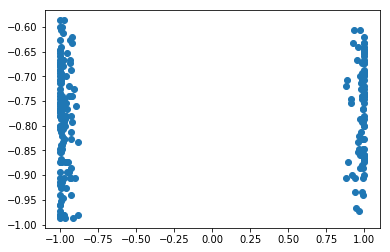

In [10]:
plt.plot(M_mom,M,'o')

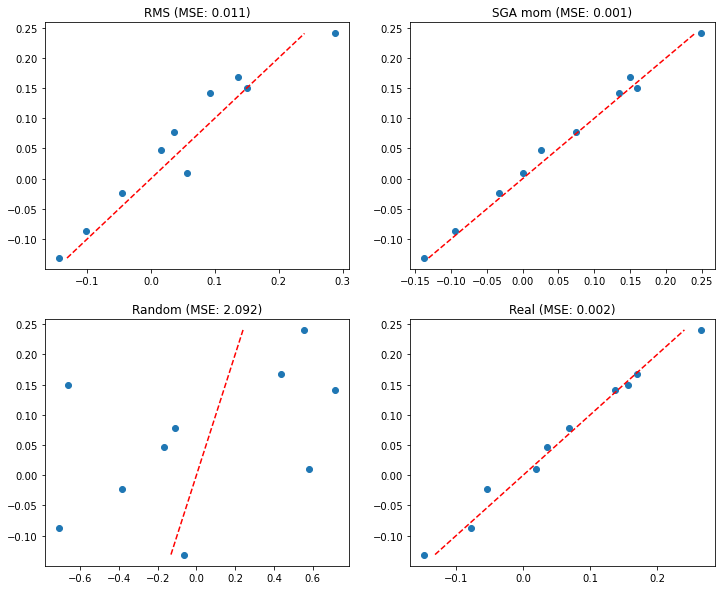

In [10]:
fig, axs = plt.subplots(2, 2 ,figsize=(12,10))
axs[0, 0].plot(M_rms,M,'o')
axs[0, 0].set_title('RMS (MSE: '+str(np.sum((M_rms-M)**2))[:5]+')')
axs[0, 1].plot(M_mom,M,'o')
axs[0, 1].set_title('SGA mom (MSE: '+str(np.sum((M_mom-M)**2))[:5]+')')
axs[1, 0].plot(M_rand,M,'o')
axs[1, 0].set_title('Random (MSE: '+str(np.sum((M_rand-M)**2))[:5]+')')
axs[1, 1].plot(M_real,M,'o')
axs[1, 1].set_title('Real (MSE: '+str(np.sum((M_real-M)**2))[:5]+')')


for ax in axs.flat:
    ax.plot([min(M),max(M)],[min(M),max(M)],'--',color ='red')


### Comparison between correlation matrix

In [11]:
C_o = C_and_Cdot(S,dt)[0].flatten()
C_mom = C_and_Cdot(S_mom,dt)[0].flatten()
C_rms = C_and_Cdot(S_rms,dt)[0].flatten()
C_rand = C_and_Cdot(S_rand,dt)[0].flatten()
C_real = C_and_Cdot(S_real,dt)[0].flatten()

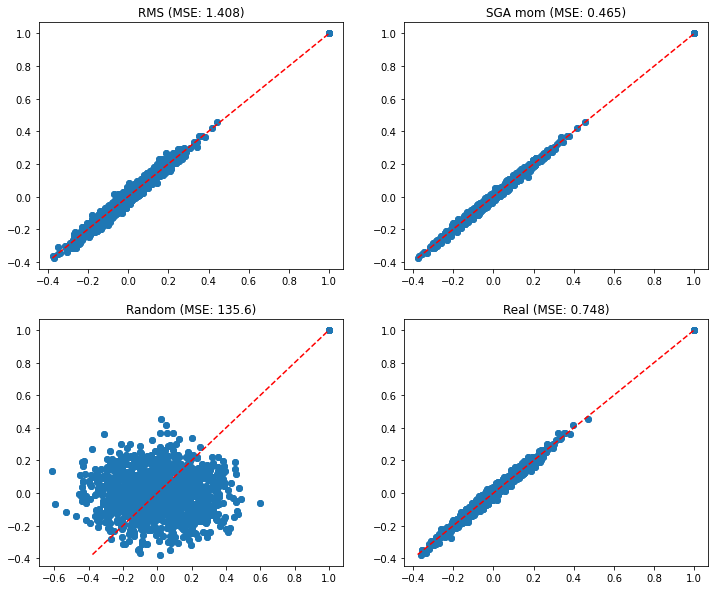

In [12]:
fig, axs = plt.subplots(2, 2 ,figsize=(12,10))
axs[0, 0].plot(C_rms,C_o,'o')
axs[0, 0].set_title('RMS (MSE: '+str(np.sum((C_rms-C_o)**2))[:5]+')')
axs[0, 1].plot(C_mom,C_o,'o')
axs[0, 1].set_title('SGA mom (MSE: '+str(np.sum((C_mom-C_o)**2))[:5]+')')
axs[1, 0].plot(C_rand,C_o,'o')
axs[1, 0].set_title('Random (MSE: '+str(np.sum((C_rand-C_o)**2))[:5]+')')
axs[1, 1].plot(C_real,C_o,'o')
axs[1, 1].set_title('Real (MSE: '+str(np.sum((C_real-C_o)**2))[:5]+')')


for ax in axs.flat:
    ax.plot([min(C_o),max(C_o)],[min(C_o),max(C_o)],'--',color ='red')


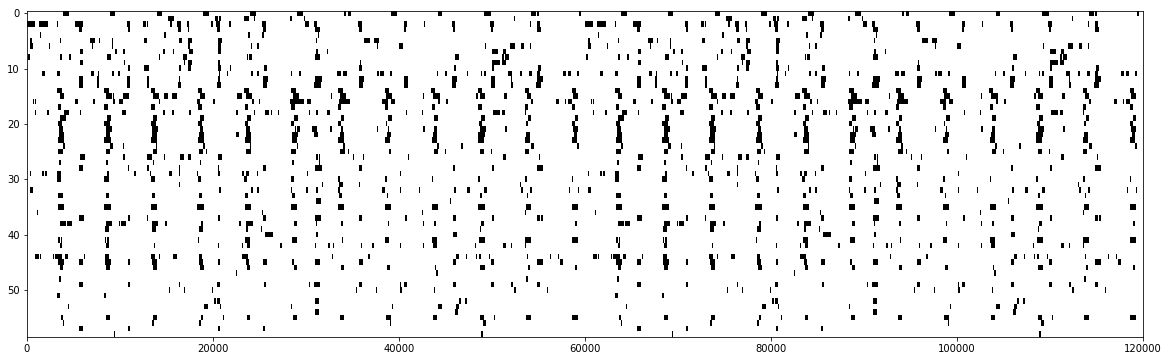

In [41]:
plt.figure(figsize=(20,6))
plt.imshow(S_2[:,:120000],aspect = 'auto', cmap = 'binary', interpolation = 'None')

In [40]:
if np.all(S_2[:,:60000]==S_2[:,60000:120000]) == True: print("fail")

fail


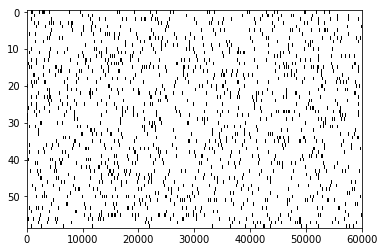

In [58]:
plt.imshow(S_mom[:,:60000],aspect = 'auto', cmap = 'binary', interpolation = 'None')